<a href="https://colab.research.google.com/github/ratulb/deep_drive/blob/main/mnist_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **Big-endian binary format image files**: (*-images-idx3-ubyte)


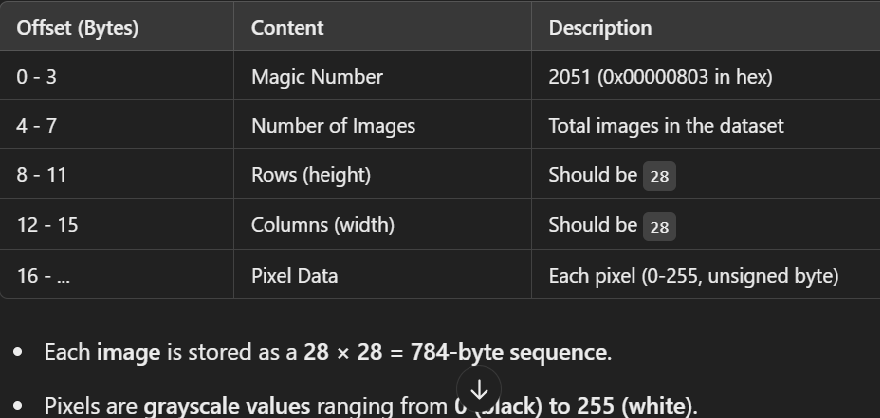

**Big-endian binary format label files**:(*-labels-idx1-ubyte)

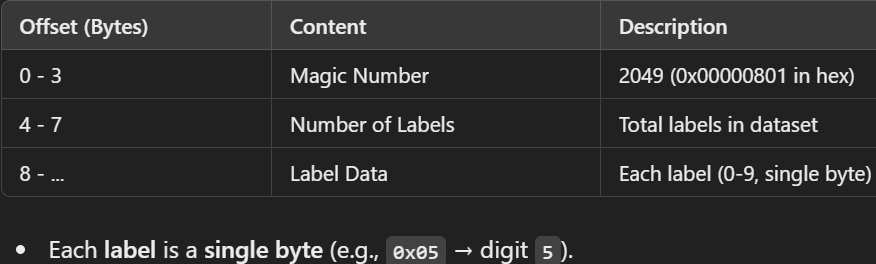

In [ ]:
import urllib.request
import os
import gzip
import shutil
import struct
import numpy as np
from tqdm import tqdm

class MNISTLoader:
    def __init__(self, base_url="https://azureopendatastorage.blob.core.windows.net/mnist/", folder=None):
        """
        Initialize the MNISTLoader class, set dataset URLs, and trigger downloading and extraction.

        Parameters:
        base_url (str): URL where MNIST dataset files are hosted.
        folder (str): Folder where dataset files will be stored. If None, uses the current working directory.
        """
        self.base_url = base_url
        self.files = ["train-images-idx3-ubyte.gz",
                      "train-labels-idx1-ubyte.gz",
                      "t10k-images-idx3-ubyte.gz",
                      "t10k-labels-idx1-ubyte.gz"]
        self.folder = folder
        self.download()
        self.extract()

    def download(self):
        """
        Downloads the MNIST dataset files from the given base URL if they are not already present.
        """
        # Define the folder where files will be saved
        if self.folder is None:
            self.folder = os.getcwd()  # Default to current working directory
        else:
            self.folder = os.path.join(os.getcwd(), self.folder)

        # Create the folder if it does not exist
        if not os.path.exists(self.folder):
            os.makedirs(self.folder)

        # Download each file if not already present
        for file in tqdm(self.files, desc="Downloading MNIST files"):
            url = self.base_url + file  # Construct full file URL
            file_path = os.path.join(self.folder, file)  # Full local file path
            if not os.path.exists(file_path):  # Avoid downloading again
                print(f"Downloading {file}...")
                urllib.request.urlretrieve(url, file_path)  # Download file

    def extract(self):
        """
        Extracts the downloaded gzip-compressed MNIST files.
        """
        for file in self.files:
            gz_path = os.path.join(self.folder, file)  # Gzipped file path
            extracted_path = os.path.join(self.folder, file[:-3])  # Remove .gz extension

            # Open the compressed file and save it uncompressed
            with gzip.open(gz_path, 'rb') as f_in, open(extracted_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)  # Extract the file

    def load(self, train=True):
        """
        Loads the MNIST dataset (train or test set) into NumPy arrays.

        Parameters:
        train (bool): If True, loads training data; otherwise, loads test data.

        Returns:
        images (numpy.ndarray): Flattened 28x28 grayscale images as a NumPy array.
        labels (numpy.ndarray): Corresponding labels as a NumPy array.
        """

        # Choose appropriate filenames based on whether we're loading training or test data
        if train:
            label_filename = "train-labels-idx1-ubyte"
            image_filename = "train-images-idx3-ubyte"
        else:
            label_filename = "t10k-labels-idx1-ubyte"
            image_filename = "t10k-images-idx3-ubyte"

        # Full file paths for the dataset
        label_path = os.path.join(self.folder, label_filename)
        image_path = os.path.join(self.folder, image_filename)
        #labels = load_labels(label_path)
        #images = load_images(image_path)
        # Read and parse label file
        with open(label_path, 'rb') as label_file:
            magic, num_labels = struct.unpack('>II', label_file.read(8))  # Read magic number and label count
            labels = np.fromfile(label_file, dtype=np.uint8)  # Read label data as uint8 array

        # Read and parse image file
        with open(image_path, 'rb') as image_file:
            magic, num_images, rows, cols = struct.unpack('>IIII', image_file.read(16))  # Read header
            images = np.fromfile(image_file, dtype=np.uint8).reshape(num_images, rows * cols)  # Read images and reshape

        return images, labels  # Return dataset as NumPy arrays


    @staticmethod
    def load_labels(label_file_path):
        """
        Load labels from a file.

        Parameters:
        label_file_path (str): Path to the label file.

        Returns:
        labels (numpy.ndarray): Labels as a NumPy array.

        This method is only for pedagogical purpose showing how to read data from mnist label data file without using resorting to any library.
        Refer to 'Big-endian binary format label files' above

        Usage:
        labels = MNISTLoader(folder='data').load_labels('./data/t10k-labels-idx1-ubyte')

        """
        with open(label_file_path, 'rb') as f:
            # Read the magic number (4 bytes)
            magic = int.from_bytes(f.read(4), byteorder='big')
            assert magic == 2049, f"Invalid MNIST label file: {magic}"

            # Read number of labels (4 bytes)
            num_labels = int.from_bytes(f.read(4), byteorder='big')

            # Read label data (1 byte per label)
            labels = [f.read(1)[0] for _ in range(num_labels)]
            #labels = [int.from_bytes(f.read(1), byteorder="big") for _ in range(num_labels)]
            labels = np.array(labels)

        return labels  # Returns NumPy array of integers (0-9)

    @staticmethod
    def load_images(image_file_path):
        """
        Load images from a file.

        Parameters:
        image_file_path (str): Path to the image file.

        Returns:
        images (numpy.ndarray): Images as a NumPy array.

        This method is only for pedagogical purpose showing how to read data from mnist image data file without using resorting to any library.
        Refer to 'Big-endian binary format image files' above
        Usage:
        images = MNISTLoader(folder='data').load_images('./data/t10k-images-idx3-ubyte')

        """
        with open(image_file_path, 'rb') as f:
            # Read the magic number (4 bytes)
            magic = int.from_bytes(f.read(4), byteorder='big')
            assert magic == 2051, f"Invalid MNIST image file: {magic}"

            # Read number of images (4 bytes)
            num_images = int.from_bytes(f.read(4), byteorder='big')

            # Read number of rows (4 bytes) and columns (4 bytes)
            rows = int.from_bytes(f.read(4), byteorder='big')
            cols = int.from_bytes(f.read(4), byteorder='big')
            assert rows == 28 and cols == 28, "Images are not 28x28"

            # Read image data (each image is rows × cols = 28 × 28 = 784 bytes)
            images = []
            for _ in range(num_images):
                image = [[f.read(1)[0] for _ in range(cols)] for _ in range(rows)]
                images.append(image)  # Store each 28x28 image as a list of lists
            images = np.array(images)  # Convert to NumPy array
        return images # Returns a NumPy array of size 28x28 (each pixel is 0-255)

    @staticmethod
    def from_arff(base_url='https://www.openml.org/data/download/52667/mnist_784.arff', folder=None):
        import numpy as np
        from scipy.io import arff

        if folder is None:
            folder = os.getcwd()  # Default to current working directory
        else:
            folder = os.path.join(os.getcwd(), folder)
        # Create the folder if it does not exist
        if not os.path.exists(folder):
            os.makedirs(folder)
        # Download each file if not already present
        url = base_url + 'mnist_784.arff'  # Construct full file URL
        file_path = os.path.join(folder, 'mnist_784.arff')  # Full local file path

        if not os.path.exists(file_path):  # Avoid downloading again
            print("Downloading mnist_784.arff...")
            urllib.request.urlretrieve(url, file_path) # Download file
        print("Processing mnist_784.arff...")
        data, meta = arff.loadarff(file_path)

        # feature_names -> ('pixel1', 'pixel2', 'pixel3', ...., 'pixel782', 'pixel783', 'pixel784', 'class')

        col_names = data.dtype.names
        images_and_labels = np.empty((len(data), len(col_names)), dtype=np.uint8)
        for i, row in tqdm(enumerate(data), total=len(data), desc="Processing Data", unit="rows"):
        #for i, row in enumerate(data):
            images_and_labels[i] = [row[col] for col in col_names]
        images = images_and_labels[:, 0:784]
        labels = images_and_labels[:, -1]

        #feature_names = data.dtype.names
        #feature_cols = feature_names[:-1]
        #images = np.empty((len(data), len(feature_cols)), dtype=np.uint8)
        #labels = np.empty(len(data), dtype=np.uint8)
        #for i, row in tqdm(enumerate(data), total=len(data), desc="Processing Data", unit="rows"):
        #for i, row in enumerate(data):
            #images[i] = [row[col] for col in feature_cols]
            #labels[i] = row['class']
        print("Done...")
        return images, labels



In [ ]:
labels = MNISTLoader.load_labels('/content/data/t10k-labels-idx1-ubyte')
images = MNISTLoader.load_images('/content/data/t10k-images-idx3-ubyte')

In [ ]:
labels.shape, images.shape

In [ ]:
labels = MNISTLoader(folder='data').load_images('./data/t10k-images-idx3-ubyte')

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
image = images[1].reshape(28, 28)/255.0
plt.imshow(image, cmap='gray')  # 'gray' colormap for grayscale images
plt.axis('off')  # Hide axes for better visualization
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5), sharex=True, sharey=True)
axes = axes.flatten()
for i in range(10):
    img = images[labels == i][0].reshape(28, 28)
    img = img/255.0
    axes[i].imshow(img, cmap='Greys')
axes[0].set_xticks([])
axes[0].set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 5), sharex=True, sharey=True)
axes = axes.flatten()
for i in range(25):
    img = images[labels == 9][i].reshape(28, 28)
    img = img/255.0
    axes[i].imshow(img, cmap='Greys')
axes[0].set_xticks([])
axes[0].set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
urllib.request.urlretrieve('https://www.openml.org/data/download/52667/mnist_784.arff', './mnist_784.arff')

In [ ]:
loader = MNISTLoader(folder='data')
images, labels = loader.load()
images = images/255.0

In [ ]:
!wget https://www.openml.org/data/download/52667/mnist_784.arff

In [ ]:
from scipy.io import arff
start = time.time()
data, meta = arff.loadarff('/content/mnist_784.arff')
print("Total: ", time.time() - start)

In [ ]:
import time
start = time.time()
images0, labels0 = MNISTLoader.from_arff()
print("Total: ", time.time() - start)

In [ ]:
images1, labels1 = MNISTLoader().load()

In [ ]:
images.shape, images1.shape, type(images[0][0]), type(images1[0][0])

In [ ]:
np.alltrue(images[:60000].astype(np.uint8) == images1)

In [ ]:
type(labels), labels.shape, type(labels1), labels1.shape, type(labels[100]), type(labels1[100])

In [ ]:
np.alltrue(labels[:60000] == labels1)

In [ ]:
import time
start = time.time()
col_names = data.dtype.names
images_and_labels = np.empty((len(data), len(col_names)), dtype=np.uint8)
#for i, row in tqdm(enumerate(data), total=len(data), desc="Processing Data", unit="rows"):
for i, row in enumerate(data):
  images_and_labels[i] = [row[col] for col in col_names]
images = images_and_labels[:, 0:784]
labels = images_and_labels[:, -1]
print("Total: ", time.time() - start)

In [ ]:
np.alltrue(images0 == images)

In [ ]:
np.alltrue(labels0 == labels)

In [ ]:
23.763367414474487 + 39.178258657455444